In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()


Saving World_MerchantFleet_CLEAN.csv to World_MerchantFleet_CLEAN (2).csv


In [3]:
df_fleet_cleaned = pd.read_csv("World_MerchantFleet_CLEAN (2).csv")

In [4]:
# 1 Load dataset
df = pd.read_csv("World_MerchantFleet_CLEAN.csv")

# Keep only 1980–2025
df = df[(df['Year'] >= 1980) & (df['Year'] <= 2025)].reset_index(drop=True)

# DWT in millions
df['DWT_million'] = df['Dead weight tons in thousands'] / 1000

# Avoid zeros (needed for log)
eps = 1e-3
df['DWT_million'] = df['DWT_million'].clip(lower=eps)

# Log transform (IMPORTANT)
df['DWT_log'] = np.log1p(df['DWT_million'])

# Encode categorical features
economy_encoder = LabelEncoder()
ship_encoder = LabelEncoder()

df['Economy_enc'] = economy_encoder.fit_transform(df['Economy'])
df['ShipType_enc'] = ship_encoder.fit_transform(df['ShipType'])

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler_y = MinMaxScaler()
df['DWT_scaled'] = scaler_y.fit_transform(
    df[['DWT_log']]
)

In [6]:
# 2 Create sequences per economy + ship (CORRECT VERSION)

def create_sequences(df, time_steps=5):
    Xs, ys, meta = [], [], []

    for (_, _), g in df.groupby(['Economy_enc', 'ShipType_enc']):
        g = g.sort_values('Year')

        if len(g) <= time_steps:
            continue

        # ONLY scaled target as feature
        X = g[['DWT_scaled']].values
        y = g['DWT_scaled'].values

        for i in range(len(g) - time_steps):
            Xs.append(X[i:i+time_steps])
            ys.append(y[i+time_steps])

            meta.append({
                'Economy_enc': g.iloc[i+time_steps]['Economy_enc'],
                'ShipType_enc': g.iloc[i+time_steps]['ShipType_enc'],
                'Year': g.iloc[i+time_steps]['Year']
            })

    return np.array(Xs), np.array(ys), pd.DataFrame(meta)


time_steps = 5
X_seq, y_seq, meta = create_sequences(df, time_steps=time_steps)

In [7]:
# 3 Train / Test split (time-based)
split_year = meta['Year'].quantile(0.8)

train_idx = meta['Year'] <= split_year
test_idx  = meta['Year'] > split_year

X_train = X_seq[train_idx]
X_test  = X_seq[test_idx]

y_train = y_seq[train_idx]
y_test  = y_seq[test_idx]

meta_train = meta[train_idx].reset_index(drop=True)
meta_test  = meta[test_idx].reset_index(drop=True)

In [9]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test  = y_test.astype('float32')

In [10]:
# 5 Build LSTM model (RECOMMENDED)

inp = Input(shape=(time_steps, X_train.shape[2]))

x = LSTM(
    64,
    recurrent_dropout=0.1
)(inp)

x = Dropout(0.2)(x)

out = Dense(1)(x)

model = Model(inp, out)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape :", y_test.shape)

print("X_train dtype:", X_train.dtype)
print("y_train dtype:", y_train.dtype)


X_train shape: (39728, 5, 1)
X_test shape : (9170, 5, 1)
y_train shape: (39728,)
y_test shape : (9170,)
X_train dtype: float32
y_train dtype: float32


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0034 - val_loss: 3.5162e-04
Epoch 2/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.1193e-04 - val_loss: 2.6589e-04
Epoch 3/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.3609e-04 - val_loss: 1.8028e-04
Epoch 4/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.5933e-04 - val_loss: 1.6456e-04
Epoch 5/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.3569e-04 - val_loss: 1.7018e-04
Epoch 6/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.1996e-04 - val_loss: 1.6146e-04
Epoch 7/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.0849e-04 - val_loss: 1.5230e-04
Epoch 8/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3.9705e-04 - val_loss: 1.6936e-04
Epoch 9/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.9192e-04 - val_loss: 2.1630e-04
Epoch 10/100
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 4.1982e-04 - val_loss: 2.3323e-04
Epoch 11/100
1242/1242 ━━━━━━━

In [15]:
# تنفيذ التدريب بدون Early Stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.9661e-04 - val_loss: 1.7350e-04
Epoch 2/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.9214e-04 - val_loss: 1.6561e-04
Epoch 3/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3.7221e-04 - val_loss: 1.6326e-04
Epoch 4/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.9267e-04 - val_loss: 1.9154e-04
Epoch 5/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.8508e-04 - val_loss: 1.5964e-04
Epoch 6/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.7504e-04 - val_loss: 1.8296e-04
Epoch 7/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 3.8723e-04 - val_loss: 1.6095e-04
Epoch 8/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3.7443e-04 - val_loss: 1.6888e-04
Epoch 9/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.7223e-04 - val_loss: 1.6366e-04
Epoch 10/50
1242/1242 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 3.9252e-04 - val_loss: 1.5482e-04
Epoch 11/50
1242/1242 ━━━━━━━━━━━━━━━━

In [16]:
# 7 Predict train and test (CORRECT)

y_train_pred = model.predict(X_train, verbose=0)
y_test_pred  = model.predict(X_test, verbose=0)

# لا clip
# لا تعديل على y_train أو y_test

y_train_true = y_train
y_test_true  = y_test


In [17]:
# Inverse MinMax
y_train_true_real = scaler_y.inverse_transform(y_train_true.reshape(-1, 1))
y_test_true_real  = scaler_y.inverse_transform(y_test_true.reshape(-1, 1))

y_train_pred_real = scaler_y.inverse_transform(y_train_pred)
y_test_pred_real  = scaler_y.inverse_transform(y_test_pred)

# Inverse log
y_train_true_real = np.expm1(y_train_true_real)
y_test_true_real  = np.expm1(y_test_true_real)

y_train_pred_real = np.expm1(y_train_pred_real)
y_test_pred_real  = np.expm1(y_test_pred_real)

In [18]:
# 8 Build prediction DataFrames (REAL VALUES)

pred_train_df = meta_train.copy()
pred_train_df['DWT_pred_million'] = y_train_pred_real.flatten()
pred_train_df['DWT_true_million'] = y_train_true_real.flatten()

pred_train_df['Economy'] = economy_encoder.inverse_transform(
    pred_train_df['Economy_enc'].astype(int)
)
pred_train_df['ShipType'] = ship_encoder.inverse_transform(
    pred_train_df['ShipType_enc'].astype(int)
)

pred_test_df = meta_test.copy()
pred_test_df['DWT_pred_million'] = y_test_pred_real.flatten()
pred_test_df['DWT_true_million'] = y_test_true_real.flatten()

pred_test_df['Economy'] = economy_encoder.inverse_transform(
    pred_test_df['Economy_enc'].astype(int)
)
pred_test_df['ShipType'] = ship_encoder.inverse_transform(
    pred_test_df['ShipType_enc'].astype(int)
)




In [13]:
def safe_percentage_error(y_true, y_pred, min_value=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true >= min_value
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]) * 100


In [19]:
'0000' in economy_encoder.classes_

True

In [20]:
if '0000' in economy_encoder.classes_:
    world_economy_enc = economy_encoder.transform(['0000'])[0]
else:
    world_economy_enc = None
    print("⚠️ Economy '0000' not found in dataset")

In [21]:
future_predictions = []

# Economy: World
world_economy_enc = economy_encoder.transform(['0000'])[0]

for ship_label in ship_encoder.classes_:
    ship_enc = ship_encoder.transform([ship_label])[0]

    # Historical data (ONLY scaled target)
    hist_data = df[
        (df['Economy_enc'] == world_economy_enc) &
        (df['ShipType_enc'] == ship_enc)
    ].sort_values('Year')

    if len(hist_data) < time_steps:
        continue

    # Initial sequence (DWT_scaled only)
    current_seq = hist_data['DWT_scaled'].values[-time_steps:]
    current_seq = current_seq.reshape(1, time_steps, 1)

    for year in range(2026, 2031):

        # Predict (still scaled + log)
        y_pred_scaled = model.predict(current_seq, verbose=0)

        future_predictions.append({
            'Year': year,
            'Economy_enc': world_economy_enc,
            'ShipType_enc': ship_enc,
            'DWT_scaled_pred': y_pred_scaled[0, 0]
        })

        # Recursive update
        current_seq = np.roll(current_seq, -1, axis=1)
        current_seq[0, -1, 0] = y_pred_scaled[0, 0]


In [22]:
future_df = pd.DataFrame(future_predictions)

# Inverse MinMax
future_df['DWT_log_pred'] = scaler_y.inverse_transform(
    future_df[['DWT_scaled_pred']]
)

# Inverse log
future_df['DWT_pred_million'] = np.expm1(future_df['DWT_log_pred'])

In [23]:
future_df['Economy'] = economy_encoder.inverse_transform(
    future_df['Economy_enc']
)
future_df['ShipType'] = ship_encoder.inverse_transform(
    future_df['ShipType_enc']
)

In [24]:
future_pivot = future_df.pivot(
    index='Year',
    columns='ShipType',
    values='DWT_pred_million'
)

print("✅ Future Predictions 2026–2030 (DWT_million)")
print(future_pivot)


✅ Future Predictions 2026–2030 (DWT_million)
ShipType            0            1            2           3           4  \
Year                                                                      
2026      2888.516357   764.060974  1201.107056   95.168701  420.415833   
2027      3552.847168   896.241455  1438.139282  104.792480  494.178528   
2028      4569.298828  1096.941162  1791.554321  118.140617  589.630615   
2029      5943.557129  1361.669312  2260.339111  134.199844  707.940247   
2030      7694.352539  1689.170654  2847.672607  152.568802  851.001404   

ShipType           5  
Year                  
2026      318.749573  
2027      366.923859  
2028      433.488586  
2029      517.081482  
2030      617.270813  


In [25]:
from sklearn.metrics import r2_score, mean_squared_error

def compute_metrics(df, pe_func, min_value=1.0):
    metrics = []
    for ship, g in df.groupby('ShipType'):
        if len(g['DWT_true_million'].unique()) > 1:
            rmse = np.sqrt(
                mean_squared_error(
                    g['DWT_true_million'],
                    g['DWT_pred_million']
                )
            )
            r2 = r2_score(
                g['DWT_true_million'],
                g['DWT_pred_million']
            )
            pe = pe_func(
                g['DWT_true_million'],
                g['DWT_pred_million'],
                min_value=min_value
            )
        else:
            rmse = r2 = pe = np.nan

        metrics.append({
            'ShipType': ship,
            'RMSE': rmse,
            'R2': r2,
            'PE': pe,
            'N': len(g)
        })

    return pd.DataFrame(metrics)


In [29]:
import numpy as np

def safe_percentage_error(y_true, y_pred, min_value=1.0):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mask = y_true >= min_value
    if mask.sum() == 0:
        return np.nan

    return np.mean(
        np.abs(y_true[mask] - y_pred[mask]) / y_true[mask]
    ) * 100

In [32]:
metrics_train_df = compute_metrics(
    pred_train_df,
    safe_percentage_error,
    min_value=1.0
)

metrics_test_df = compute_metrics(
    pred_test_df,
    safe_percentage_error,
    min_value=1.0
)

In [33]:
metrics_df = (
    pd.merge(
        metrics_train_df,
        metrics_test_df,
        on='ShipType',
        suffixes=('_Train', '_Test')
    )
)

metrics_df = metrics_df.rename(columns={
    'RMSE_Train': 'Train_RMSE',
    'R2_Train':   'Train_R2',
    'PE_Train':   'Train_PE',
    'RMSE_Test':  'Test_RMSE',
    'R2_Test':    'Test_R2',
    'PE_Test':    'Test_PE'
})

metrics_df = metrics_df[
    [
        'ShipType',
        'Train_RMSE', 'Train_R2', 'Train_PE',
        'Test_RMSE',  'Test_R2',  'Test_PE'
    ]
]

metrics_df = metrics_df.round(2)

print("✅ Combined Metrics per ShipType (Train vs Test)")
print(metrics_df)

✅ Combined Metrics per ShipType (Train vs Test)
   ShipType  Train_RMSE  Train_R2  Train_PE  Test_RMSE  Test_R2  Test_PE
0         0       16.75      0.99     10.63      37.89     0.98    11.24
1         1        5.38      0.99     11.73       9.27     0.99    15.44
2         2        6.72      0.99      9.76      14.38     0.99     8.61
3         3        1.39      0.99      8.81       0.62     1.00     4.83
4         4        1.54      0.99      8.42       2.48     1.00     6.45
5         5        2.17      0.98      9.97       2.43     0.99     5.68


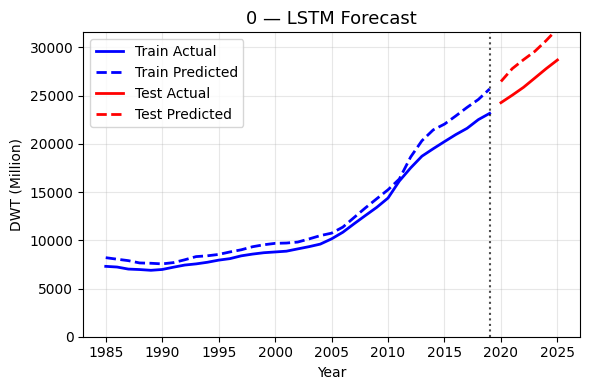

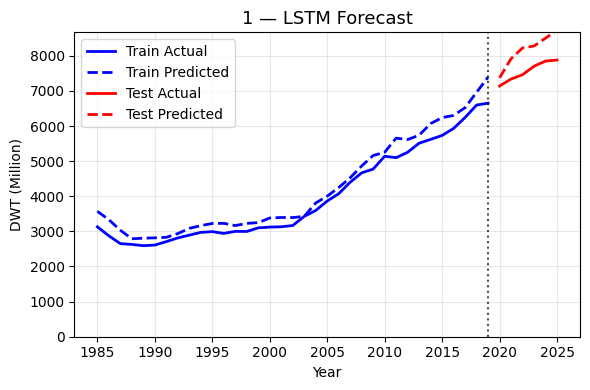

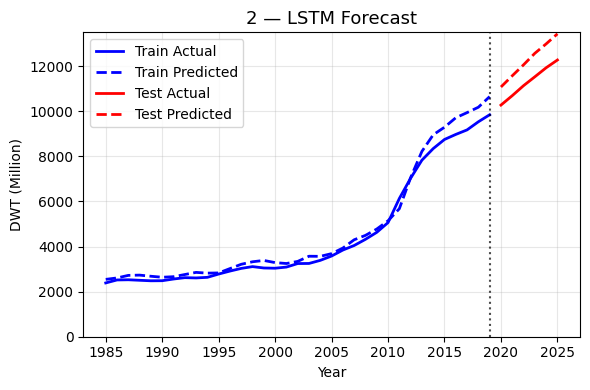

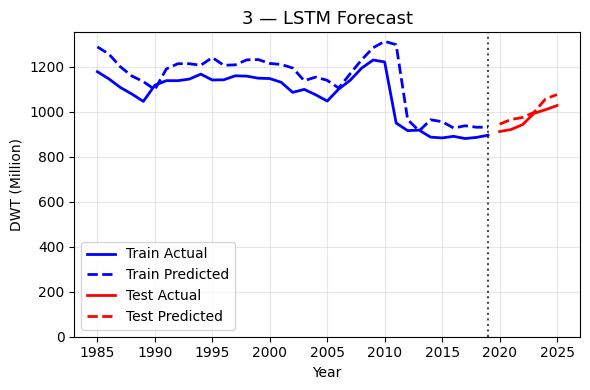

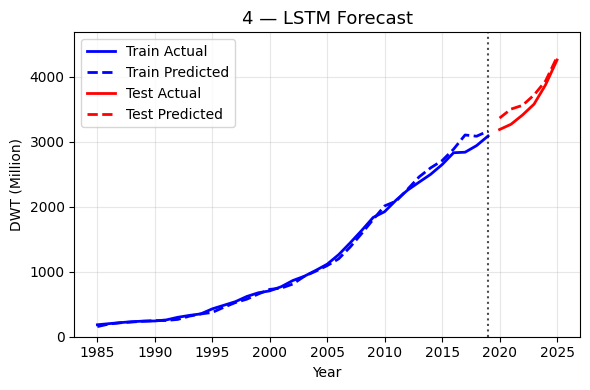

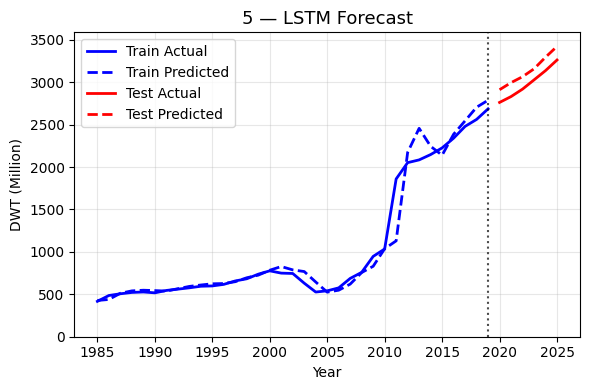

In [34]:
import matplotlib.pyplot as plt

for ship_type in sorted(pred_train_df['ShipType'].unique()):

    # ===== Train =====
    train_g = (
        pred_train_df[pred_train_df['ShipType'] == ship_type]
        .groupby('Year', as_index=False)
        .agg({
            'DWT_true_million': 'sum',
            'DWT_pred_million': 'sum'
        })
        .sort_values('Year')
    )

    # ===== Test =====
    test_g = (
        pred_test_df[pred_test_df['ShipType'] == ship_type]
        .groupby('Year', as_index=False)
        .agg({
            'DWT_true_million': 'sum',
            'DWT_pred_million': 'sum'
        })
        .sort_values('Year')
    )

    if train_g.empty or test_g.empty:
        continue

    plt.figure(figsize=(6, 4))

    # ---- Train ----
    plt.plot(
        train_g['Year'], train_g['DWT_true_million'],
        color='blue', linewidth=2, label='Train Actual'
    )
    plt.plot(
        train_g['Year'], train_g['DWT_pred_million'],
        color='blue', linestyle='--', linewidth=2, label='Train Predicted'
    )

    # ---- Test ----
    plt.plot(
        test_g['Year'], test_g['DWT_true_million'],
        color='red', linewidth=2, label='Test Actual'
    )
    plt.plot(
        test_g['Year'], test_g['DWT_pred_million'],
        color='red', linestyle='--', linewidth=2, label='Test Predicted'
    )

    # 🔹 فاصل زمني بين Train و Test
    split_year = train_g['Year'].max()
    plt.axvline(split_year, color='black', linestyle=':', alpha=0.7)

    # 🔹 تثبيت نطاق Y (يمنع الطيران)
    ymax = max(
        train_g['DWT_true_million'].max(),
        test_g['DWT_true_million'].max()
    )
    plt.ylim(0, ymax * 1.1)

    plt.title(f'{ship_type} — LSTM Forecast', fontsize=13)
    plt.xlabel('Year')
    plt.ylabel('DWT (Million)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
